### Training a convolutional neural network (with 1 convolutional layer and 1 fully connected layer)

아래 코드는 다음 항목을 구현한다.
1. Convolutional layer와 fully connected (linear) layer를 각각 1개씩 포함하는 convolutional neural network 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Neural network 모델의 parameter에 대한 gradient 연산
4. 학습된 Neural network 모델 parameter를 적용하여 test data의 classification 결과 도출

In [1]:
# package 불러오기
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os

# utility functions

# function: make labels one-hot vectors
def make_labels_onehot(labels, num_cls):
    num_data = labels.shape[0]
    labels_1hot = np.zeros((num_data,num_cls))
    labels_1hot[np.arange(num_data),labels[:]] = 1
    return labels_1hot

# function: visualize sample images
def VisualizeBatchData(batch_data, batch_sz):
    f, axarr = plt.subplots(batch_sz)
    ddim_sq = int(np.sqrt(batch_data[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(batch_sz):
        axarr[i].imshow(batch_data[i][:].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

# function: visualize neuron weight matrix for gradient descent
def VisualizeLinearWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

# function: visualize convolutional kernel weights for gradient descent
def VisualizeConvWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

##### 셀1: Toy 데이터셋 생성하기

아래 코드는 구현하고자 하는 CNN에 적절한 toy dataset을 생성한다.
Toy dataset은 3개 클래스의 영상들로 구성되며 클래스 별로 각 영상은 검은 배경에 class 0: 세로 줄, class 1: 가로 줄, class 2: 네모 박스를 내포하는 형태이다.

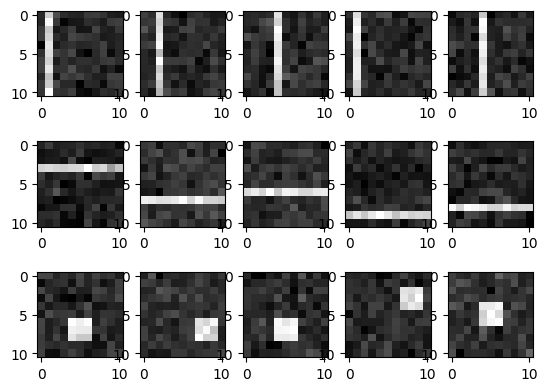

In [2]:
# set toy dataset image configuration
img_sz = 11
num_img_per_cls = 100
num_cls = 3
num_imgs = num_img_per_cls*num_cls
db_imgs = np.zeros((num_imgs,img_sz,img_sz))

ri_v = np.random.randint(img_sz-2, size=num_img_per_cls)
ri_h = np.random.randint(img_sz-2, size=num_img_per_cls)
re_sz = 3
ri_rp = np.random.randint(img_sz-4, size=(num_img_per_cls,2))
for i in range(num_img_per_cls):
    # class 0: vertical line at random position
    db_imgs[i,:,ri_v[i]+1] = 1
    # class 1: horizontal line at random position
    db_imgs[num_img_per_cls+i,ri_h[i]+1,:] = 1
    # class 1: horizontal line at random position
    db_imgs[num_img_per_cls*2+i,ri_rp[i,0]+2:ri_rp[i,0]+2+re_sz,ri_rp[i,1]+2:ri_rp[i,1]+2+re_sz] = 1

# add noise with normal distribution
noise_w = 0.1
db_imgs = db_imgs + noise_w*np.random.randn(num_cls*num_img_per_cls,img_sz,img_sz)

# visualize sample images
f, axarr = plt.subplots(3,5) 
for i in range(5):
    axarr[0,i].imshow(db_imgs[i,:,:],cmap='gray')
    axarr[1,i].imshow(db_imgs[num_img_per_cls+i,:,:],cmap='gray')
    axarr[2,i].imshow(db_imgs[num_img_per_cls*2+i,:,:],cmap='gray')
plt.show()

# construct labels
db_labels = np.zeros((num_cls*num_img_per_cls),dtype='int8')
db_labels[:num_img_per_cls] = 0
db_labels[num_img_per_cls:2*num_img_per_cls] = 1
db_labels[2*num_img_per_cls:] = 2

# pre-process sample images
db_data = db_imgs.copy()
# subtract mean
data_mean = np.mean(db_data)
db_data = db_data - data_mean

##### 문제1: Toy dataset - training/test 분할

다음 코드에서는 이전 문제에서 생성한 영상 DB를 임의로 학습용 training 데이터와 실험용 test 데이터로 분할한다.

In [4]:
# 
idxs = np.arange(num_img_per_cls) # array of sorted index numbers
np.random.shuffle(idxs) # random shuffle
tr_ratio = 0.8

num_tr_data = int(num_img_per_cls*tr_ratio)
tr_data = np.zeros((num_tr_data*num_cls,img_sz,img_sz))
tr_data[:num_tr_data,:] = db_data[idxs[:num_tr_data],:] # class 0 학습 data 확보
tr_data[num_tr_data:2*num_tr_data,:] = db_data[num_img_per_cls+idxs[:num_tr_data],:] # class 0 학습 data 확보

tr_labels = np.zeros((num_tr_data*num_cls),dtype='int8')
# 학습용 레이블 데이터 확보
tr_labels[:num_tr_data] = db_labels[idxs[:num_tr_data]]
tr_labels[num_tr_data:2*num_tr_data] = db_labels[num_img_per_cls+idxs[:num_tr_data]]

num_te_data = num_img_per_cls-num_tr_data
print(num_te_data)
te_data = np.zeros((num_te_data*num_cls,img_sz,img_sz))
# 테스트용 영상 데이터 확보
te_data[:num_te_data,:] = db_data[idxs[:num_te_data],:]
te_data[num_te_data:2*num_te_data,:] = db_data[num_img_per_cls+idxs[:num_te_data],:]

te_labels = np.zeros((num_te_data*num_cls),dtype='int8')
te_labels[:num_te_data] = db_labels[idxs[num_tr_data:num_img_per_cls]]
te_labels[num_te_data:2*num_te_data] = db_labels[num_img_per_cls+idxs[num_tr_data:num_img_per_cls]]

te_data = te_data.reshape(te_data.shape[0], te_data.shape[1], te_data.shape[2])
print(tr_data.shape)

20
(240, 11, 11)


##### 문제2: Convolutional neural network 모델의 local gradient 연산 정의

다음 코드는 아래 그림과 같이 1개의 hidden layer를 갖는 neural network의 객체를 정의하는 class의 코드이다.

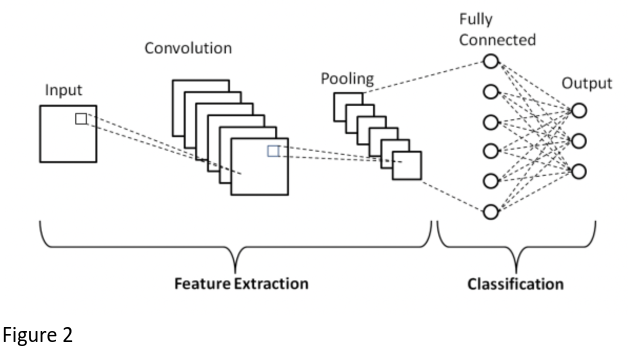


In [173]:
class ConvNet2:
    def __init__(self, img_sz, k_sz, k_num, num_cls):
        # img_sz is tuple of image width and height (w,h) 
        self.img_sz = img_sz
        self.kernel_sz = k_sz
        self.kernel_num = k_num
        self.num_cls = num_cls
        # kernel parameters for convolutional neurons
        self.K1 = 0.001 * np.random.randn(self.kernel_num, 1, self.kernel_sz, self.kernel_sz)
        self.b1 = np.random.randint(k_num)
        # compute the dimension of convolutional output
        self.K_outdim = (img_sz - k_sz + 1) ** 2
        # parameters for fully connected (linear) layer
        self.W2 = 0.001 * np.random.randn(self.K_outdim, num_cls)
        self.b2 = np.random.randint(num_cls)
        self.scores = np.zeros(num_cls)
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        # 코딩 수행 - 간단한 신경망의 연산 수행, activation 함수는 ReLU로 정의
        # training data (image array) dimension is num_imgs,img_sz,img_sz
        for i in range(batch_sz)
        # operations for convolutional layer 
        
        # operation to convert convolutional layer output to fully connected layer input
        
        # operations for fully connected layer
        
        return self.scores
    def backward(self, upstream_grad):
        # consider upstream_grad dimensions 
        # K1 dimension is k_sz x k_sz x num_k
         # YOUR CODE HERE - K1의 local gradient 계산
        # b1 dimension is 1 x num_k
         # YOUR CODE HERE - b1의 local gradient 계산
        
        # W2 dimension is K_outdim x num_class
         # YOUR CODE HERE - W2의 local gradient 계산
        # b2 dimension is 1 x num_class
         # YOUR CODE HERE - b2의 local gradient 계산
        grad = {'K1':grad_K1, 
                'b1':grad_b1,
                'W2':grad_W2, 
                'b2':grad_b2}
        return grad
    def grad_descent(self, grad, lr):
        grad_K1 = grad['K1']
        grad_b1 = grad['b1']
        self.K1 = self.K1 - lr*grad_K1
        self.b1 = self.b1 - lr*grad_b1
        grad_W2 = grad['W1']
        grad_b2 = grad['b1']
        self.W2 = self.W2 - lr*grad_W2
        self.b2 = self.b2 - lr*grad_b2
    def visualize_kernels(self):
        f, axarr = plt.subplots(self.kernel_num)
        for j in range(self.kernel_num):
            axarr[j].imshow(self.K1[j,:,:],cmap='gray')
    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W2.shape[0]))
        for j in range(self.num_cls):
            axarr[j].imshow(self.W2[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()


##### 문제3: Softmax loss 함수의 local gradient 연산 정의

다음 코드는 Softmax 함수 기반의 cross-entropy loss 함수와 이를 기준으로 모델을 학습하는데 필요한 gradient를 계산하는 과정을 포함한다.

In [174]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.labels = 0
        self.data = 0
        self.probs = 0
        self.num_cls = num_cls
    def compute_probs(self, data):
        scores = self.model.forward(data)
        self.model_scores = scores
        # compute softmax function
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        softmax_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        self.probs = softmax_probs
        
        return self.probs    
    def compute_loss(self, data, labels):
        self.data = data
        self.compute_probs(data)
        
        num_samples = data.shape[0]
        correct_class_prob = self.probs[np.arange(num_samples), labels]
        loss = -np.log(correct_class_prob).sum() / num_samples
        self.loss = loss
        
        return self.loss
    def compute_grad(self, labels, batch_sz):
        # score dimensions should be N x M
        z = self.probs
        # grad_z dimensions should also be N x M
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
    
        return self.model.backward(grad_z, batch_sz)


##### 문제4: Gradient descent 알고리즘 구현

다음 코드는 gradient descent 알고리즘으로 학습 데이터에 대해 MLP neural network를 학습하는 코드이다.

In [ ]:
def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    num_samples = db_data.shape[0]
    idxs = np.arange(num_samples)
    np.random.shuffle(idxs)  # 데이터 인덱스를 무작위로 섞음

    batch_data = db_data[idxs[:batch_sz]]  # 미니 배치 데이터 추출
    batch_labels = db_labels[idxs[:batch_sz]]  # 미니 배치 레이블 추출

    # VisualizeBatchData(batch_data,batch_sz)
    return batch_data, batch_labels

def train_convnet2(db_data, db_labels, num_cls, lr, batch_sz, num_iter, kernel_sz, kernel_num):
    # define & initialize MLP neural network classifier
    num_data = db_data.shape[0]
    img_sz = db_data.shape[1]
    model = ConvNet2(img_sz, kernel_sz, kernel_num, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        batch_data = batch_data.reshape(batch_data.shape[0], 1, batch_data.shape[1], batch_data.shape[2])
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        # print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad()
        # update model parameters using gradient
        model.grad_descent(grad, lr)
    model.visualize_weights()
    return model

lr = 0.001
batch_sz = 8
num_iter = 100
kernel_sz = 5
kernel_num = 16
model = train_convnet2(tr_data, tr_labels, kernel_sz, kernel_num, num_cls, lr, batch_sz, num_iter, kernel_sz, kernel_num)

##### 문제5: 학습된 모델을 이용한 test data classification

다음 코드에서는 학습된 ConvNet2를 이용하여 테스트 데이터의 판별 결과를 도출한다.

In [ ]:
te_scores = model.forward(te_data)
# 판별 결과를 클래스로 변환 (가장 높은 점수를 갖는 클래스 선택)
te_predictions = np.argmax(te_scores, axis=1)

# 정확도 계산
# 예측값과 실제 레이블이 일치하는 경우 True
correct_predictions = (te_predictions == test_labels) 
# 정확한 예측의 비율 계산 
Acc = np.mean(correct_predictions.astype(float))  

print('Classification accuracy= {}%'.format(Acc*100))